In [1]:
using Plots
using LinearAlgebra
using HCubature
using StaticArrays

# Hartree-Fock Program

The task is to write a Hartree-Fock program that can solve problems involving hydrogen atoms. The STO-3G basis set should be used. 

In general we have that for a STO-$n$G basis set centered on an atom at $R$ and for a given principal quantum number $s$ at a point $r$ is

$$\Psi_{\mathrm{STO-}n\mathrm{G}}(s, R, r) = \sum_{i=1}^n c_i \phi_i(R,r)$$

and

$$\phi_i(R, r) = \left(\frac{2\alpha_i}{\pi}\right)^{3/4} e^{-\alpha |R-r|^2}$$

where the $s$-dependence comes in through the coefficients and exponents.

In the task we know that $n=3$ and we are given then exponents $\alpha_i$ as the values give in the textbook. Since I do not have the textbook here, I will use the values given by [basis set exchange](https://www.basissetexchange.org/) (the JSON format can be used for downloading to clearly see which values are exponents and which are coefficents).

From the basis set exchange we see that the exponents are:

|            |                  |
|------------|------------------|
|$\alpha_1$  |  3.425250914     |
|$\alpha_2$  |  0.6239137298    |
|$\alpha_3$  |  0.1688554040    |

In [2]:
exponents = [3.425250914, 0.6239137298, 0.1688554040]

3-element Array{Float64,1}:
 3.425250914 
 0.6239137298
 0.168855404 

Now we can start coding. Let's start by making a gaussian function. To simplify the code a bit, we will implement two versions: one where we use the same look as above, and another where we just care about the distance $d = |R - r|$ (this is just tio make it easier to vectorize later).

In [3]:
gaussian_primitive(α::Number, d::Number) = (2 * α / π ) ^ (3/4) * exp(-α * d ^ 2)
gaussian_primitive(α, r::SArray{Tuple{3},Float64,1,3}) = gaussian_primitive(α, norm(r)^2)
gaussian_primitive(α, r::AbstractVector{Number}) = gaussian_primitive(α, norm(r)^2)

gaussian_primitive(α, R, r) = gaussian_primitive(α, norm(R - r)^2) # reusing our function above, and assuming cartesian coordinates

gaussian_primitive (generic function with 4 methods)

In [4]:
norm([1,1,1])

1.7320508075688772

Now we can check this out by trying to make a nice plot.

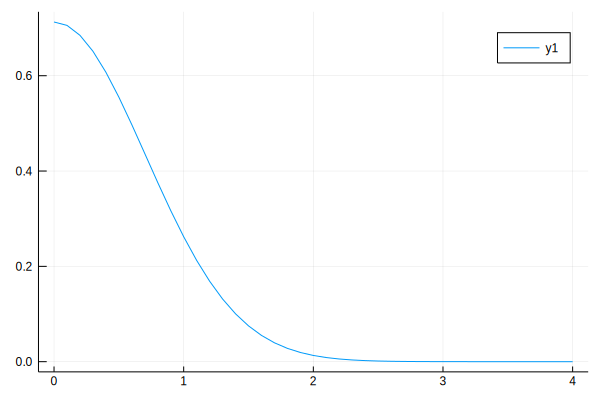

In [5]:
α = 1
d = 0:0.1:4 

y = gaussian_primitive.(α, d) # Use the dot before the arguments to vectorize

plot(d, y)

We should also integrate this so that we can normalize it later. We want to integrate over all real space, and we have a function of the form 

$$
ae^{-b(x^2 + y^2 + z^2)} = ae^{-bx^2}e^{-by^2}e^{-bz^2} \Rightarrow a\int_{-\infty}^\infty e^{-bz^2} \int_{-\infty}^\infty e^{-by^2} \int_{-\infty}^\infty e^{-bx^2} \mathrm{d}x\mathrm{d}y\mathrm{d}z
$$

We will use numeric integration as it is more generally applicable without having to solve a bunch of integrals for each new basis you use.

In [16]:
f(relative_coordinate) = gaussian_primitive(exponents[1], relative_coordinate)

g(r) = norm(r) <= 1 ? 1 : 0
println(g(1))

In [ ]:
function monte_carlo_integral(f, x_min::AbstractArray{Number,1}, x_max::AbstractArray{Number,1}, N::Integer, f_min::Number f_max::Number)
    total_area = prod(x_max .- x_min) * (f_max - f_min)
    points_inside = 0
    for n=1:N
        points_inside += rv <= abs(f(v)) 
    end
end

In [16]:
int_max = 1e1
int_min = -int_max
hcubature(g, [int_min; int_min; int_min], [int_max; int_max; int_max])

1


InterruptException: InterruptException:

In [7]:
g

g (generic function with 1 method)

It can be convinient to work in spherical coordinates now, that is:

$$
x = \rho\sin\theta\cos\varphi\\
y = \rho\sin\theta\sin\varphi\\
z = \rho\cos\theta\\
$$

where I have used $\rho$ instead of $r$ when compairing to the figure below.

![image.png](https://upload.wikimedia.org/wikipedia/commons/4/4f/3D_Spherical.svg)

Looks good! So now we can start making the actual STO-$n$G function.

In [8]:
function STOnG(coefficients, exponents, d)
    return sum([c * gaussian_primitive.(α, d) for (c, α) in zip(coefficients, exponents)])
end

STOnG (generic function with 1 method)

Which we again test to make sure that it produces what we expect.

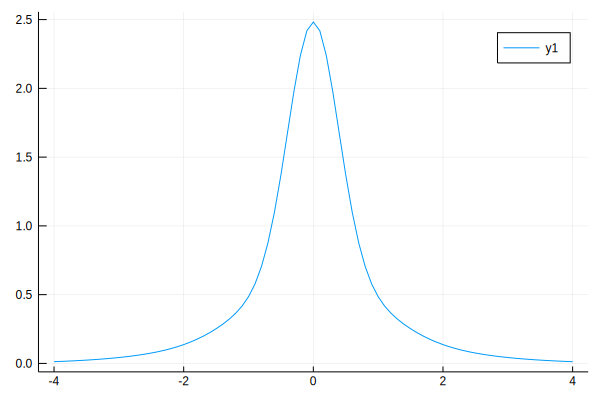

In [9]:
coefficients = [1, 1, 1]
d = -4:0.1:4

y = STOnG(coefficients, exponents, d)

plot(d, y)

Now, if we only could evaluate the energy of this single orbital, we would be able to calculate the energy for a single hydrogen atom.

We can call this the core Hamiltonian, $\hat{H}_{\mathrm{core}}$, i.e. the energy of a single electron due to the interaction with the core as well as kinetic energy.

$$\hat{H}^{\mathrm{core}} = -\frac{\nabla^2}{2} - \sum_{\mathrm{\gamma}} \frac{Z_\gamma}{|r_{\gamma} - r|}$$

where we sum over all nuclei $\gamma$.

The trickiest part of this expression is the second derivatives arising from the $\nabla^2$. However, due to rotational symmetry we can see that when this acts on our gaussian functions we get

$$\nabla^2\phi_i = \frac{\partial^2 \phi_i}{\partial d^2} = 2 \alpha_i (2 \alpha_i d^2 - 1) \left(\frac{2\alpha_i}{\pi}\right)^{3/4} e^{-\alpha_i d^2}$$

In [10]:
gaussian_laplacian(α, d) = 2α * (2α^2 - 1) * gaussian_primitive(α, d)

function STOnG_laplacian(coefficients, exponents, d)
    return sum([c * gaussian_laplacian.(α, d) for (c, α) in zip(coefficients, exponents)])
end

STOnG_laplacian (generic function with 1 method)

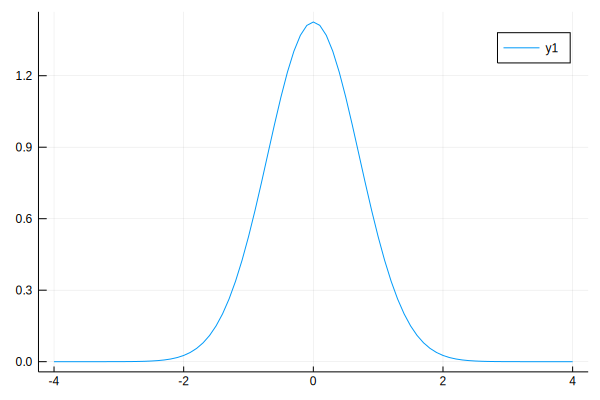

In [11]:
α = 1
d = -4:0.1:4 # okay, we can't have neagtive distances, but it makes for a prettier plot...

y = gaussian_laplacian.(α, d) # Use the dot before the arguments to vectorize

plot(d, y)

In [12]:
coefficients = [1, 1, 1]
exponents = [3.425250914, 0.6239137298, 0.1688554040]

nuclei_pos = [0,0,0]
charge = 1
nbr_electrons = 1

d = -4:0.01:4

-4.0:0.01:4.0

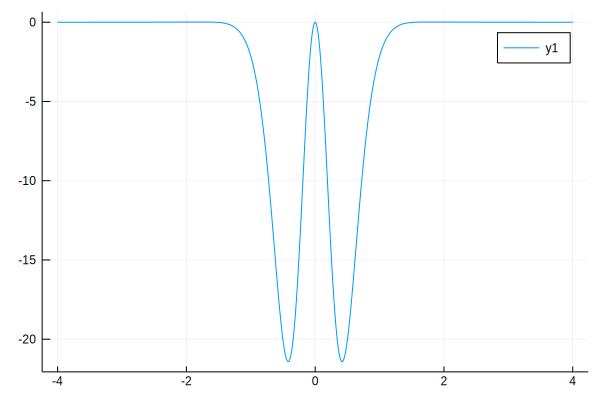

In [19]:
kinetic_energy = -1/2 .* d.^2 .*STOnG(coefficients, exponents, d) .* STOnG_laplacian(coefficients, exponents, d)
coloumb_energy = - charge./abs.(d) .* d.^2 .* STOnG(coefficients, exponents, d) .* STOnG(coefficients, exponents, d)
total_energy = kinetic_energy + coloumb_energy


plot(d, kinetic_energy)

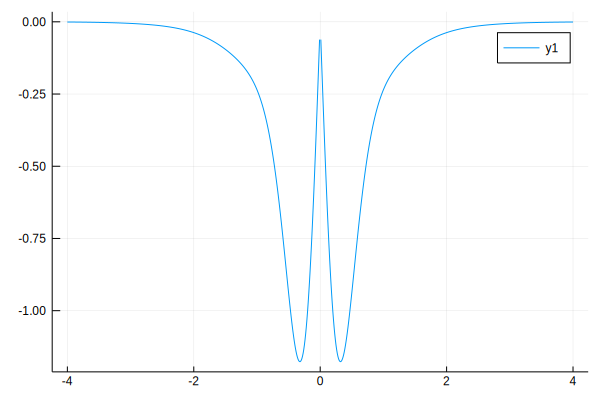

In [20]:
plot(d, coloumb_energy)

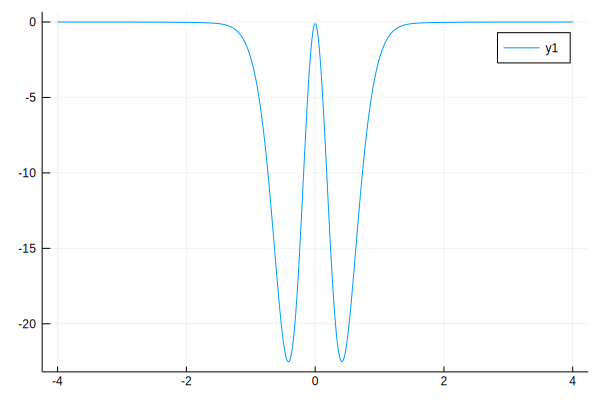

In [21]:
plot(d, total_energy)